In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [3]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Set up logging**

In [5]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

**Download NLTK tokenizer models (only the first time)**

In [6]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bjuncklaus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bjuncklaus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Prepare Corpus

In [57]:
filenames = sorted(glob.glob("data/*.txt"))

In [58]:
print("Found:")
filenames

Found:


['data/plots_full.txt']

In [60]:
corpus_raw = u""
for filename in filenames:
    print("Reading '{0}'...".format(filename))
    with codecs.open(filename, "r", "utf-8") as file:
        corpus_raw += file.read()
    print("Corpus is {0} characters long".format(len(corpus_raw)))

Reading 'data/plots_full.txt'...
Corpus is 79261768 characters long


**Split the corpus into sentences**

In [10]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [11]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [12]:
#convert into a list of words
#remove unnnecessary, split into words, no hyphens
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [13]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [14]:
print(raw_sentences[15])
print(sentence_to_wordlist(raw_sentences[15]))

Through a young pig named Squealer, Napoleon claims credit for the windmill idea.
['Through', 'a', 'young', 'pig', 'named', 'Squealer', 'Napoleon', 'claims', 'credit', 'for', 'the', 'windmill', 'idea']


In [61]:
token_count = sum([len(sentence) for sentence in sentences])
print("The corpus contains {0:,} tokens".format(token_count))

The corpus contains 13,801,737 tokens


## Train Word2Vec

In [16]:
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
downsampling = 1e-3

seed = 1

In [17]:
w2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [18]:
w2vec.build_vocab(sentences)

2017-11-24 21:59:23,280 : INFO : collecting all words and their counts
2017-11-24 21:59:23,284 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-11-24 21:59:23,401 : INFO : PROGRESS: at sentence #10000, processed 216021 words, keeping 21021 word types
2017-11-24 21:59:23,485 : INFO : PROGRESS: at sentence #20000, processed 429653 words, keeping 29909 word types
2017-11-24 21:59:23,556 : INFO : PROGRESS: at sentence #30000, processed 638375 words, keeping 36266 word types
2017-11-24 21:59:23,634 : INFO : PROGRESS: at sentence #40000, processed 853201 words, keeping 41846 word types
2017-11-24 21:59:23,720 : INFO : PROGRESS: at sentence #50000, processed 1070832 words, keeping 46726 word types
2017-11-24 21:59:23,803 : INFO : PROGRESS: at sentence #60000, processed 1287921 words, keeping 51476 word types
2017-11-24 21:59:23,887 : INFO : PROGRESS: at sentence #70000, processed 1504595 words, keeping 55718 word types
2017-11-24 21:59:23,971 : INFO : PROGRESS: 

2017-11-24 21:59:29,772 : INFO : resetting layer weights


In [19]:
print("Word2Vec vocabulary length:", len(w2vec.wv.vocab))

Word2Vec vocabulary length: 93734


**Start training, this might take a minute or two...**

In [21]:
w2vec.train(sentences, total_examples=w2vec.corpus_count, epochs=w2vec.iter)

2017-11-24 21:05:13,578 : INFO : training model with 4 workers on 93734 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2017-11-24 21:05:14,602 : INFO : PROGRESS: at 0.20% examples, 106320 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:05:15,615 : INFO : PROGRESS: at 0.46% examples, 120591 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:05:16,633 : INFO : PROGRESS: at 0.67% examples, 115191 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:05:17,723 : INFO : PROGRESS: at 0.95% examples, 119845 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:05:18,748 : INFO : PROGRESS: at 1.24% examples, 125616 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:05:19,849 : INFO : PROGRESS: at 1.51% examples, 126531 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:05:20,884 : INFO : PROGRESS: at 1.80% examples, 129404 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:05:21,903 : INFO : PROGRESS: at 2.06% examples, 129988 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:05:22,911 : INFO : P

2017-11-24 21:06:38,572 : INFO : PROGRESS: at 17.18% examples, 106234 words/s, in_qsize 8, out_qsize 0
2017-11-24 21:06:39,585 : INFO : PROGRESS: at 17.38% examples, 106211 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:06:40,716 : INFO : PROGRESS: at 17.61% examples, 106139 words/s, in_qsize 6, out_qsize 1
2017-11-24 21:06:41,716 : INFO : PROGRESS: at 17.82% examples, 106223 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:06:42,745 : INFO : PROGRESS: at 18.04% examples, 106271 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:06:43,772 : INFO : PROGRESS: at 18.24% examples, 106236 words/s, in_qsize 8, out_qsize 0
2017-11-24 21:06:44,826 : INFO : PROGRESS: at 18.47% examples, 106261 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:06:45,874 : INFO : PROGRESS: at 18.69% examples, 106289 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:06:46,889 : INFO : PROGRESS: at 18.90% examples, 106268 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:06:47,921 : INFO : PROGRESS: at 19.11% examples, 106306 wor

2017-11-24 21:08:03,710 : INFO : PROGRESS: at 33.99% examples, 104948 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:08:04,808 : INFO : PROGRESS: at 34.11% examples, 104628 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:08:05,826 : INFO : PROGRESS: at 34.26% examples, 104451 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:08:06,901 : INFO : PROGRESS: at 34.44% examples, 104329 words/s, in_qsize 8, out_qsize 1
2017-11-24 21:08:08,459 : INFO : PROGRESS: at 34.55% examples, 103745 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:08:09,530 : INFO : PROGRESS: at 34.70% examples, 103546 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:08:10,619 : INFO : PROGRESS: at 34.85% examples, 103338 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:08:11,671 : INFO : PROGRESS: at 35.06% examples, 103368 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:08:12,821 : INFO : PROGRESS: at 35.26% examples, 103256 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:08:14,041 : INFO : PROGRESS: at 35.49% examples, 103232 wor

2017-11-24 21:09:29,596 : INFO : PROGRESS: at 49.56% examples, 101662 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:09:30,714 : INFO : PROGRESS: at 49.77% examples, 101664 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:09:31,793 : INFO : PROGRESS: at 50.01% examples, 101709 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:09:32,983 : INFO : PROGRESS: at 50.24% examples, 101711 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:09:34,113 : INFO : PROGRESS: at 50.47% examples, 101735 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:09:35,239 : INFO : PROGRESS: at 50.69% examples, 101732 words/s, in_qsize 8, out_qsize 0
2017-11-24 21:09:36,260 : INFO : PROGRESS: at 50.89% examples, 101740 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:09:37,278 : INFO : PROGRESS: at 51.10% examples, 101752 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:09:38,324 : INFO : PROGRESS: at 51.29% examples, 101723 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:09:39,372 : INFO : PROGRESS: at 51.47% examples, 101665 wor

2017-11-24 21:10:55,609 : INFO : PROGRESS: at 66.16% examples, 101528 words/s, in_qsize 8, out_qsize 0
2017-11-24 21:10:56,776 : INFO : PROGRESS: at 66.39% examples, 101536 words/s, in_qsize 6, out_qsize 1
2017-11-24 21:10:57,903 : INFO : PROGRESS: at 66.62% examples, 101556 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:10:58,980 : INFO : PROGRESS: at 66.85% examples, 101591 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:10:59,988 : INFO : PROGRESS: at 67.06% examples, 101602 words/s, in_qsize 6, out_qsize 1
2017-11-24 21:11:01,072 : INFO : PROGRESS: at 67.28% examples, 101612 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:11:02,208 : INFO : PROGRESS: at 67.51% examples, 101629 words/s, in_qsize 8, out_qsize 0
2017-11-24 21:11:03,323 : INFO : PROGRESS: at 67.73% examples, 101651 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:11:04,331 : INFO : PROGRESS: at 67.94% examples, 101684 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:11:05,399 : INFO : PROGRESS: at 68.14% examples, 101677 wor

2017-11-24 21:12:22,236 : INFO : PROGRESS: at 83.34% examples, 101993 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:12:23,327 : INFO : PROGRESS: at 83.53% examples, 101964 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:12:24,458 : INFO : PROGRESS: at 83.70% examples, 101907 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:12:25,471 : INFO : PROGRESS: at 83.89% examples, 101897 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:12:26,577 : INFO : PROGRESS: at 84.09% examples, 101881 words/s, in_qsize 8, out_qsize 0
2017-11-24 21:12:27,585 : INFO : PROGRESS: at 84.29% examples, 101890 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:12:28,598 : INFO : PROGRESS: at 84.48% examples, 101880 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:12:29,619 : INFO : PROGRESS: at 84.67% examples, 101885 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:12:30,638 : INFO : PROGRESS: at 84.87% examples, 101890 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:12:31,726 : INFO : PROGRESS: at 85.06% examples, 101863 wor

2017-11-24 21:13:47,762 : INFO : PROGRESS: at 98.95% examples, 100936 words/s, in_qsize 8, out_qsize 0
2017-11-24 21:13:48,846 : INFO : PROGRESS: at 99.13% examples, 100900 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:13:49,851 : INFO : PROGRESS: at 99.24% examples, 100821 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:13:50,856 : INFO : PROGRESS: at 99.39% examples, 100772 words/s, in_qsize 6, out_qsize 1
2017-11-24 21:13:51,865 : INFO : PROGRESS: at 99.58% examples, 100766 words/s, in_qsize 7, out_qsize 0
2017-11-24 21:13:52,995 : INFO : PROGRESS: at 99.80% examples, 100766 words/s, in_qsize 8, out_qsize 0
2017-11-24 21:13:54,026 : INFO : PROGRESS: at 99.91% examples, 100682 words/s, in_qsize 6, out_qsize 0
2017-11-24 21:13:54,367 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-11-24 21:13:54,467 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-11-24 21:13:54,511 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-1

52441207

**Save to file, can be useful later**

In [22]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [23]:
w2vec.save(os.path.join("trained", "model.w2v"))

2017-11-24 21:14:18,001 : INFO : saving Word2Vec object under trained/model.w2v, separately None
2017-11-24 21:14:18,003 : INFO : storing np array 'syn0' to trained/model.w2v.wv.syn0.npy
2017-11-24 21:14:18,189 : INFO : not storing attribute syn0norm
2017-11-24 21:14:18,191 : INFO : storing np array 'syn1neg' to trained/model.w2v.syn1neg.npy
2017-11-24 21:14:18,567 : INFO : not storing attribute cum_table
2017-11-24 21:14:18,907 : INFO : saved trained/model.w2v


In [20]:
w2vec = w2v.Word2Vec.load(os.path.join("trained", "model.w2v"))

2017-11-24 21:59:31,476 : INFO : loading Word2Vec object from trained/model.w2v
2017-11-24 21:59:32,143 : INFO : loading wv recursively from trained/model.w2v.wv.* with mmap=None
2017-11-24 21:59:32,143 : INFO : loading syn0 from trained/model.w2v.wv.syn0.npy with mmap=None
2017-11-24 21:59:32,494 : INFO : setting ignored attribute syn0norm to None
2017-11-24 21:59:32,504 : INFO : loading syn1neg from trained/model.w2v.syn1neg.npy with mmap=None
2017-11-24 21:59:32,825 : INFO : setting ignored attribute cum_table to None
2017-11-24 21:59:32,829 : INFO : loaded trained/model.w2v


In [21]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [22]:
w2vec.wv.syn0.shape

(93734, 300)

In [31]:
all_word_vectors_matrix = w2vec.wv.syn0[:]
all_word_vectors_matrix.shape

(93734, 300)

In [32]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [33]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[w2vec.wv.vocab[word].index])
            for word in w2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [34]:
points.head(10)

,word,x,y
0,Old,6.652502,23.964895
1,Major,-18.519648,17.684511
2,the,-20.210501,-21.501089
3,old,-22.870724,7.063670
4,boar,12.722713,-19.560781
5,on,6.740707,-14.133960
6,Manor,-13.115398,15.893809
7,Farm,-1.227501,20.548262
8,summons,14.493341,-2.769326
9,animals,13.368163,-18.838202


In [35]:
sns.set_context("poster")

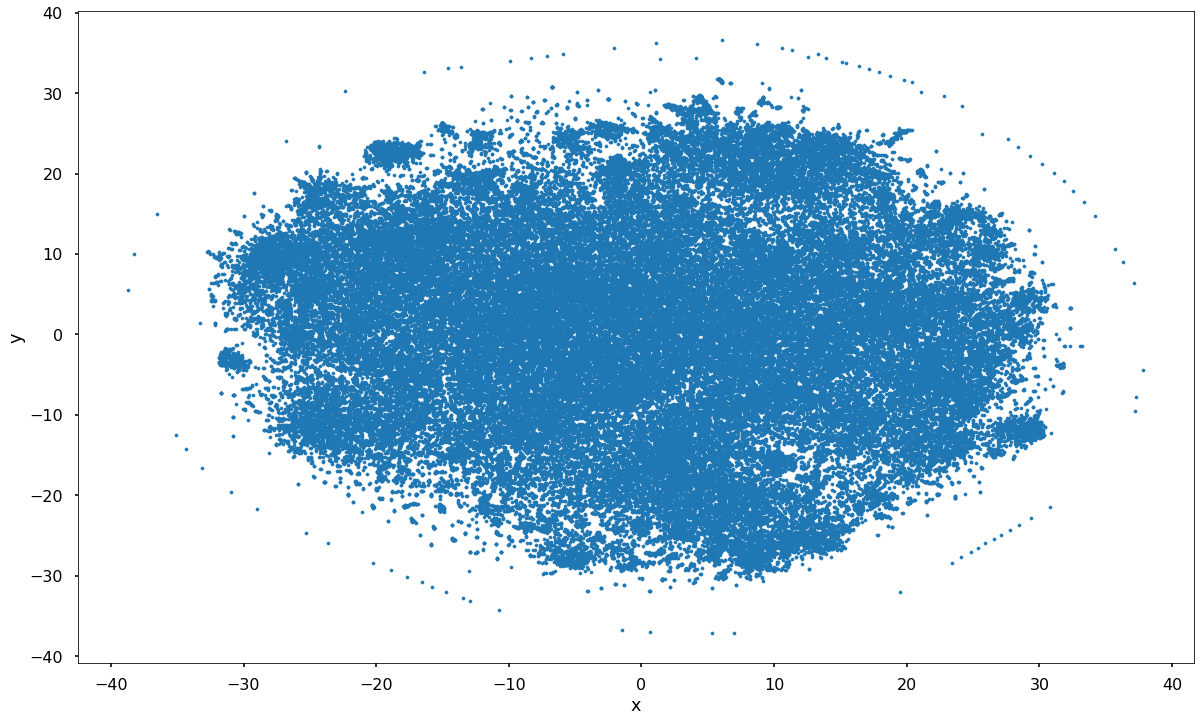

In [36]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [37]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

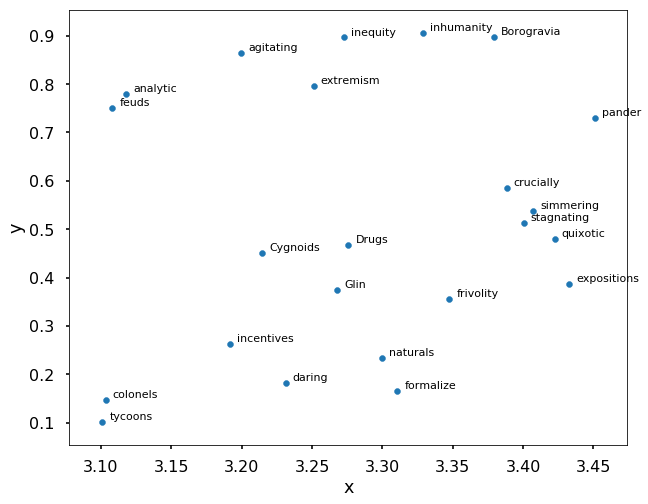

In [68]:
plot_region(x_bounds=(3, 3.5), y_bounds=(0, 1))

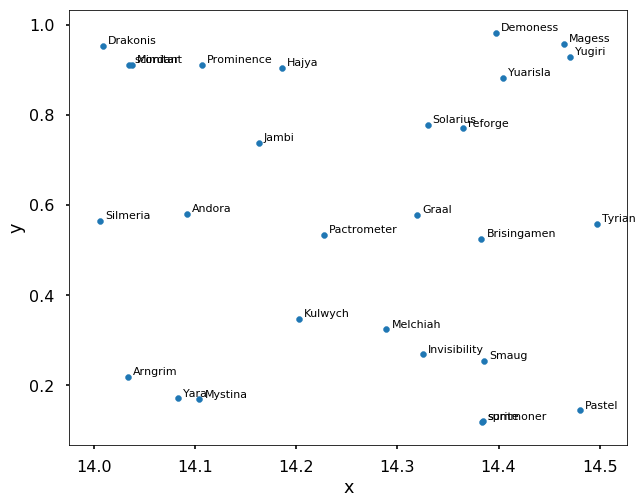

In [71]:
plot_region(x_bounds=(14, 14.5), y_bounds=(0, 1))

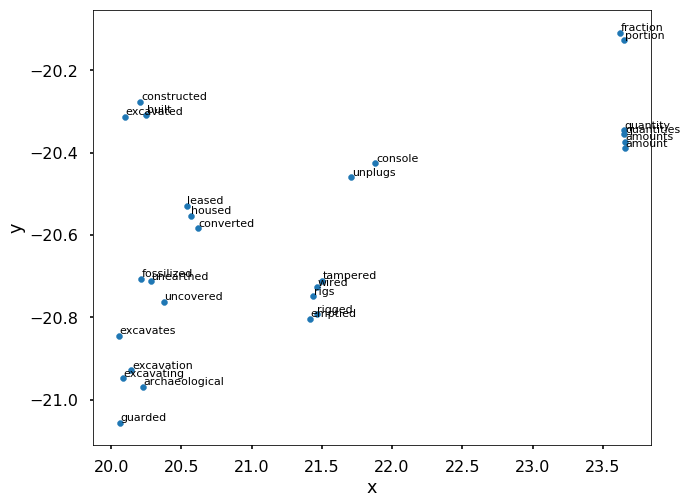

In [56]:
plot_region(x_bounds=(20, 30), y_bounds=(-22, -20))

In [52]:
w2vec.most_similar("gravity", topn=30)

[('gravitational', 0.7476991415023804),
 ('output', 0.6931130886077881),
 ('emissions', 0.6856688261032104),
 ('rotation', 0.6853864789009094),
 ('tachyon', 0.6827325224876404),
 ('propulsion', 0.6826534271240234),
 ('sensors', 0.6817935705184937),
 ('currents', 0.6785028576850891),
 ('density', 0.6761773824691772),
 ('magnetic', 0.6718573570251465),
 ('altitude', 0.670562744140625),
 ('temperatures', 0.6692144870758057),
 ('atmospheric', 0.6684892177581787),
 ('vertical', 0.6683751940727234),
 ('velocity', 0.6682177186012268),
 ('neutron', 0.6674392819404602),
 ('tau', 0.6673217415809631),
 ('curve', 0.6666178107261658),
 ('hyperdrive', 0.6640599966049194),
 ('temperature', 0.6623439192771912),
 ('thrusters', 0.6623009443283081),
 ('sensor', 0.6591739058494568),
 ('forcefield', 0.6566702723503113),
 ('gaseous', 0.6537877917289734),
 ('Starflight', 0.6532146334648132),
 ('instantaneous', 0.6518352627754211),
 ('molecules', 0.6509585380554199),
 ('implosion', 0.6505521535873413),
 ('acc

In [42]:
w2vec.most_similar("fire", topn=20)

[('ablaze', 0.5772343277931213),
 ('alight', 0.5676148533821106),
 ('afire', 0.5596336126327515),
 ('blaze', 0.5545936226844788),
 ('burning', 0.554497480392456),
 ('extinguisher', 0.546075165271759),
 ('aflame', 0.5338687300682068),
 ('douse', 0.5319390296936035),
 ('flames', 0.5293787717819214),
 ('kerosene', 0.5252149105072021),
 ('hydrant', 0.5163390040397644),
 ('gasoline', 0.5148575901985168),
 ('sprinklers', 0.5141894221305847),
 ('propane', 0.5121015906333923),
 ('dousing', 0.511151909828186),
 ('flaming', 0.5102989077568054),
 ('fires', 0.5081019997596741),
 ('extinguishes', 0.5049477815628052),
 ('extinguishers', 0.5037778615951538),
 ('latrine', 0.49910250306129456)]

In [54]:
w2vec.most_similar("love", topn=20)

[('madly', 0.6482644081115723),
 ('reciprocates', 0.596576988697052),
 ('Meenu', 0.5774663090705872),
 ('passionately', 0.5691573023796082),
 ('Esha', 0.5617328882217407),
 ('Naina', 0.5616644024848938),
 ('affection', 0.5614078044891357),
 ('Fermina', 0.5602362751960754),
 ('reciprocated', 0.5598307251930237),
 ('feelings', 0.5577186942100525),
 ('chaste', 0.5553461313247681),
 ('unrequited', 0.5523269772529602),
 ('loves', 0.551179826259613),
 ('Yoli', 0.5505610704421997),
 ('Koppikar', 0.54374098777771),
 ('Ottilie', 0.5418331623077393),
 ('pines', 0.5404753088951111),
 ('undying', 0.540323793888092),
 ('Ladislaw', 0.5397524237632751),
 ('tempestuous', 0.5389116406440735)]

In [44]:
w2vec.most_similar("king", topn=20)

[('emperor', 0.6805914044380188),
 ('King', 0.6793444156646729),
 ('sultan', 0.6113089919090271),
 ('usurper', 0.6079466938972473),
 ('prince', 0.6072194576263428),
 ('ruler', 0.6054526567459106),
 ('Navarre', 0.5988456010818481),
 ('kingdom', 0.5988266468048096),
 ('queen', 0.5977203249931335),
 ('throne', 0.5961341261863708),
 ('Uther', 0.5888413786888123),
 ('Ptolemy', 0.5884987115859985),
 ('regent', 0.5757324695587158),
 ('Sultan', 0.5756001472473145),
 ('Dumnonia', 0.5751804709434509),
 ('kings', 0.5746773481369019),
 ('Mordred', 0.5722867250442505),
 ('Gwent', 0.5695423483848572),
 ('princess', 0.5648117065429688),
 ('duke', 0.5586606860160828)]

In [73]:
w2vec.most_similar("dune", topn=20)

[('veered', 0.8632878661155701),
 ('outcropping', 0.8629933595657349),
 ('divider', 0.8628809452056885),
 ('roadway', 0.8597726821899414),
 ('taxis', 0.8587303757667542),
 ('bleachers', 0.8572412729263306),
 ('pedal', 0.8568549752235413),
 ('causeway', 0.8567897081375122),
 ('Interstate', 0.8563377857208252),
 ('bobbing', 0.8562232851982117),
 ('Torgud', 0.8558005690574646),
 ('pedals', 0.854193925857544),
 ('swerving', 0.8537850379943848),
 ('careens', 0.8536638617515564),
 ('skybike', 0.8536460995674133),
 ('careen', 0.8522658348083496),
 ('gliding', 0.8506475687026978),
 ('unmolested', 0.8499890565872192),
 ('waterlogged', 0.8499380350112915),
 ('jutting', 0.8483586311340332)]

In [84]:
w2vec.most_similar("Gandalf", topn=20)

[('Aragorn', 0.8422232866287231),
 ('Elrond', 0.8265761137008667),
 ('Rohirrim', 0.7968911528587341),
 ('Saruman', 0.7940797805786133),
 ('oden', 0.7847552299499512),
 ('Rivendell', 0.783057689666748),
 ('Sauron', 0.7820233106613159),
 ('Bilbo', 0.7752338647842407),
 ('Tirith', 0.7711160778999329),
 ('Gondor', 0.7675856947898865),
 ('Minas', 0.7673007845878601),
 ('Pippin', 0.7649665474891663),
 ('Boromir', 0.764891505241394),
 ('Mordor', 0.7541443109512329),
 ('Uruk', 0.7510342597961426),
 ('Legolas', 0.7456404566764832),
 ('Isengard', 0.7394044399261475),
 ('Denethor', 0.7355483174324036),
 ('Gimli', 0.7329443693161011),
 ('Narnians', 0.7310469746589661)]

**Linear relationships between word pairs**

In [75]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = w2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))

In [76]:
nearest_similarity_cosmul("gravity", "output", "city")
nearest_similarity_cosmul("fire", "ablaze", "woman")
nearest_similarity_cosmul("love", "madly", "heart")
nearest_similarity_cosmul("king", "emperor", "swamps")
nearest_similarity_cosmul("dune", "veered", "revolution")
nearest_similarity_cosmul("gravity", "acceleration", "tennis")

gravity is related to output, as swamps is related to city
fire is related to ablaze, as girl is related to woman
love is related to madly, as marrow is related to heart
king is related to emperor, as wooded is related to swamps
dune is related to veered, as Pakistan is related to revolution
gravity is related to acceleration, as hockey is related to tennis
